In [1]:
# coding=utf-8
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import *

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

## 1.手动构建7点人脸3D模型

In [3]:
# 手动构建7点人脸3D模型
def model_3D():
    '''
    手动构建7点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型7点矩阵 shape=(7,3)
    '''
    points_3D = np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (-75.0, -170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, -170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-150.0, 150.0, -125.0),  # 左嘴角
        (150.0, 150.0, -125.0)  # 右嘴角
    ])
    return points_3D

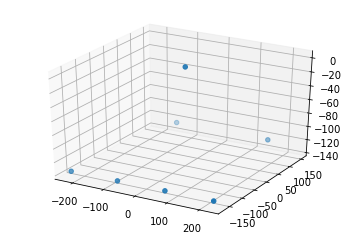

In [4]:
#------------------------------test---------------------------------
points_3D=model_3D()
#print(points_3D)
ax = plt.subplot(111, projection='3d')
ax.scatter(points_3D.T[0],points_3D.T[1],points_3D.T[2])
plt.show()

## 2.dlib提取2D图片7个特征点

In [5]:
# 获取最大的人脸(get_landmark7函数内调用)
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [6]:
# 提取68个特征点(get_landmark7函数内调用)
def get_landmarks68(img):
    '''
    用dlib提取68个特征点
    :param img: 输入图像
    :return: 68个点的坐标，shape=(68，2)
    '''
    rects = detector(img, 1)
    if len(rects) == 0:
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

In [7]:
# 注释68个标记点(测试用)
def annotate_landmarks68(im):
    '''
    注释68个标记点
    :param im: 输入图片
    :return: 带有68个标记点的图片
    '''
    img = im.copy()
    landmarks68 = get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        # cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

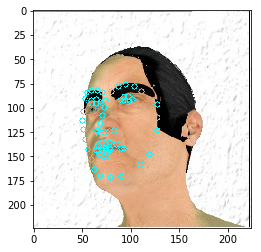

In [8]:
#------------------------------test---------------------------------
#读取图像
img0 = cv2.imread('2.jpg')
img = img0[:,:,::-1] # 调节色彩通道
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

In [9]:
# 选取dlib检测的68点中的7个特征点
def get_landmark7(img):
    '''
    用dlib获取人脸7个特征点
    :param img: 输入图片
    :return: 人脸7特征点的矩阵shape=(7,2)，若未检测到人脸，返回None
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark7 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(48).x, landmark68.part(48).y),  # 左嘴角
        (landmark68.part(54).x, landmark68.part(54).y)  # 右嘴角
    ], dtype="double")
    return landmark7

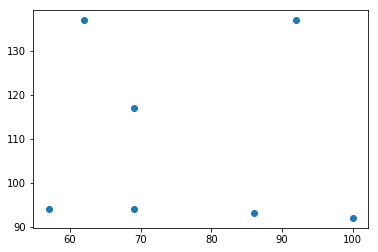

In [10]:
#------------------------------test---------------------------------
points_2D=get_landmark7(img)
#print(points_2D)
plt.scatter(points_2D.T[0],points_2D.T[1])
plt.show()

## 3.归一化,去掉平移因子的影响

In [11]:
# 归一化点
def get_normalize(points):
    '''
    归一化点
    :param 手动构建的3D模型(points_3D) 或 dlib检测到的7个特征点(points_2D)
    :return: 归一化后的点矩阵
    '''
    center = np.sum(points, axis=0) / points.shape[0]  # 中心
    L = np.sum(np.sum((points - center) ** 2, axis=1) ** 0.5)  # 归一化系数
    normalize = (points - center) / L
    return normalize, center, L

In [12]:
#------------------------------test---------------------------------
#print('points_3D=\n',points_3D,'\n','points_2D=\n',points_2D)

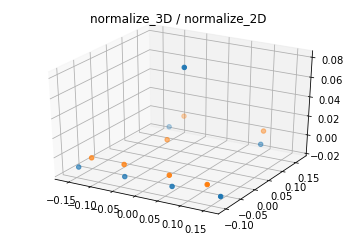

In [13]:
#------------------------------test---------------------------------
normalize_3D,center_3D, L_3D=get_normalize(points_3D)
#print('normalize_3D=\n',normalize_3D,'\ncenter_3D=',center_3D,'\nL_3D=', L_3D,'\n')
normalize_2D,center_2D, L_2D=get_normalize(points_2D)
#print('normalize_2D=\n',normalize_2D,'\ncenter_2D=',center_2D,'\nL_2D=', L_2D)
bx = plt.subplot(111, projection='3d')
bx.scatter(normalize_3D.T[0],normalize_3D.T[1],normalize_3D.T[2])
bx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D / normalize_2D')
plt.show()

## 4.求投影矩阵P

In [14]:
# 求投影矩阵P
def get_P_matrix(normalize_3D, normalize_2D):
    num = normalize_2D.shape[0]
    _ = 0  # _是要舍弃的值
    if num < 3:
        return -1
    elif num == 3:
        _, r1_T = cv2.solve(normalize_3D.T, normalize_2D.T[0], _)
        _, r2_T = cv2.solve(normalize_3D.T,normalize_2D.T[1], _)
    else:
        _, r1_T = cv2.solve(normalize_3D, normalize_2D.T[0], _, cv2.DECOMP_SVD)  # 奇异值分解
        _, r2_T = cv2.solve(normalize_3D, normalize_2D.T[1], _, cv2.DECOMP_SVD)
    r1 = r1_T.T[0]
    r2 = r2_T.T[0]
    r3 = np.cross(r1, r2)
    P = np.array([r1, r2])
    return P

In [15]:
#------------------------------test---------------------------------
P=get_P_matrix(normalize_3D,normalize_2D)
print('P=\n',P)

P=
 [[ 0.85188558 -0.00941668 -0.56709333]
 [-0.02894757  1.18623996  0.03400467]]


## 5.优化K

In [16]:
# 定义送入优化器的修正的目标函数
def f(K):
    '''
    修正的目标函数
    :param K: 待优化的参数,K*Z中的K
    :return: 修正的目标函数的值
    '''
    a = 0.01
    disparity = (normalize_2D - np.dot(normalize_3D, P.T)).T  # disparity:d=b-P*a
    objective = np.sum(disparity ** 2)  # 目标函数
    penalty = np.sum((np.ones(K.shape[0]) - K) ** 2 * normalize_3D.T[2] ** 2)  # 惩罚函数
    revised_objective = objective + a * penalty  # 修正的目标函数
    return revised_objective

In [17]:
#------------------------------test---------------------------------
#K=np.random.random(normalize_3D.shape[0])
K=[1,2,3,0,-3,-1,-1]#随机初始化
K_opt=scipy.optimize.fmin_cg(f, K,gtol=1e-15)
print('K_opt=\n',K_opt)

         Current function value: 0.000203
         Iterations: 29
         Function evaluations: 2215
         Gradient evaluations: 246
K_opt=
 [ 1.          1.00000019  1.00000022  1.00000021  0.99999998  1.00000058
  1.00000058]


In [18]:
# 得到K修正后的3D模型(A_K)
def get_normalize_3D_K(normalize_3D, K_opt):
    '''
    计算经K修正的3D模型
    :param normalize_3D: 归一化的3D模型
    :param K_opt: 最优化K
    :return: K修正的3D模型
    '''
    normalize_3D_K = np.array([normalize_3D.T[0], normalize_3D.T[1], normalize_3D.T[2] * K_opt])
    return normalize_3D_K.T

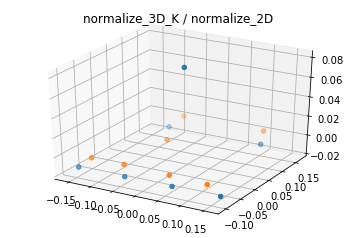

In [19]:
#------------------------------test---------------------------------
normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)
cx = plt.subplot(111, projection='3d')
cx.scatter(normalize_3D_K.T[0],normalize_3D_K.T[1],normalize_3D_K.T[2])
cx.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.title('normalize_3D_K / normalize_2D')
plt.show()

## 6.计算K修正后的最优投影矩阵

In [20]:
# 得到K修正后的最优投影矩阵
def get_P_K_opt(normalize_2D, normalize_3D_K):
    '''
    计算K修正后的最优投影矩阵
    :param normalize_2D: 归一化2D特征点
    :param normalize_3D_K: 归一化K修正3D模型
    :return:最优投影矩阵
    '''
    P_K_opt = np.dot(np.dot(normalize_2D.T, normalize_3D_K), np.linalg.inv(np.dot(normalize_3D_K.T, normalize_3D_K)))
    return P_K_opt

In [21]:
#------------------------------test---------------------------------
P_K_opt=get_P_K_opt(normalize_2D,normalize_3D_K)
print('P_K_opt=\n',P_K_opt)

P_K_opt=
 [[ 0.85188558 -0.00941669 -0.56709331]
 [-0.02894757  1.18623996  0.03400467]]


## 7.根据最优投影矩阵计算欧拉角

In [22]:
# 由最优投影矩阵计算欧拉角
def get_euler_angle(P_K_opt):
    '''
    由最优投影矩阵计算欧拉角
    :param P_opt: 最优投影矩阵
    :return: 欧拉角
    '''
    theta = np.array([0, 0, 0])  # (theta x,y,z)
    r1 = P_K_opt[0]
    r2 = P_K_opt[1]
    r3 = np.cross(r1, r2)
    #print('r3=', r3)
    theta[0] = math.atan(r3[1] / r3[2]) / math.pi * 180
    theta[1] = -math.atan(r3[0] / (r3[1] ** 2 + r3[2] ** 2) ** 0.5) / math.pi * 180
    theta[2] = math.atan(r2[0] / r1[0]) / math.pi * 180
    return theta

In [23]:
#------------------------------test---------------------------------
theta=get_euler_angle(P_K_opt)
print('theta=',theta)

theta= [  0 -33  -1]


## 8.画表示姿势的线

In [24]:
# 画表示姿势的线
def draw_line(img, points_2D,P_K_opt):
    '''
    画表示姿势的线
    :param img: 输入图片
    :param points_2D: dlib提取的2D特征点
    :return: 画有姿势线的图片
    '''
    nose_tip_2D = (int(points_2D[4][0]), int(points_2D[4][1]))
    far_3D = np.array([0.0, 0.0, 1000.0])
    far_2D = np.dot(np.dot(P_K_opt, (far_3D - center_3D) / L_3D), L_2D) + center_2D
    p1 = (int(nose_tip_2D[0]), int(nose_tip_2D[1]))
    p2 = (int(far_2D[0]), int(far_2D[1]))
    #print('p1=', p1, 'p2=', p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (255, 0, 0), 2)
    return img_with_line

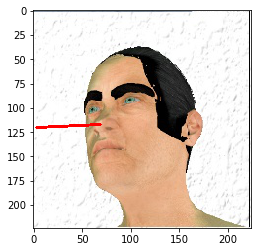

In [25]:
img_with_line=draw_line(img,points_2D,P_K_opt)
plt.imshow(img_with_line)
plt.show()